In [1]:
import os
import polars as pl
import dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
FOLDER_PATH = os.getenv("FOLDER_PATH")


dotenv.load_dotenv()
stock = "WBD"

Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 10


In [2]:
parquet_files = [f for f in os.listdir(f"{FOLDER_PATH}/data/hawkes_dataset/{stock}") if f.endswith('.parquet')]
parquet_files.sort()
print(len(parquet_files),"\n",parquet_files)
threshold = len(parquet_files)//10
threshold = 1
parquet_files = parquet_files[:threshold]
# Read and concatenate all parquet files
df = pl.concat([
    pl.read_parquet(f"{FOLDER_PATH}/data/hawkes_dataset/{stock}/{file}") 
    for file in parquet_files
])

74 
 ['WBD_2024-07-22.parquet', 'WBD_2024-07-23.parquet', 'WBD_2024-07-24.parquet', 'WBD_2024-07-25.parquet', 'WBD_2024-07-26.parquet', 'WBD_2024-07-29.parquet', 'WBD_2024-07-30.parquet', 'WBD_2024-07-31.parquet', 'WBD_2024-08-01.parquet', 'WBD_2024-08-02.parquet', 'WBD_2024-08-05.parquet', 'WBD_2024-08-06.parquet', 'WBD_2024-08-07.parquet', 'WBD_2024-08-08.parquet', 'WBD_2024-08-09.parquet', 'WBD_2024-08-12.parquet', 'WBD_2024-08-13.parquet', 'WBD_2024-08-14.parquet', 'WBD_2024-08-15.parquet', 'WBD_2024-08-16.parquet', 'WBD_2024-08-19.parquet', 'WBD_2024-08-20.parquet', 'WBD_2024-08-21.parquet', 'WBD_2024-08-22.parquet', 'WBD_2024-08-23.parquet', 'WBD_2024-08-26.parquet', 'WBD_2024-08-27.parquet', 'WBD_2024-08-28.parquet', 'WBD_2024-08-29.parquet', 'WBD_2024-08-30.parquet', 'WBD_2024-09-03.parquet', 'WBD_2024-09-04.parquet', 'WBD_2024-09-05.parquet', 'WBD_2024-09-06.parquet', 'WBD_2024-09-09.parquet', 'WBD_2024-09-10.parquet', 'WBD_2024-09-11.parquet', 'WBD_2024-09-12.parquet', 'WBD_2

In [3]:
def curate_mid_price(df,stock):
    num_entries_by_publisher = df.group_by("publisher_id").len().sort("len", descending=True)
    if len(num_entries_by_publisher) > 1:
            df = df.filter(pl.col("publisher_id") == 41)
        
        
    if stock == "GOOGL":
        df = df.filter(pl.col("ts_event").dt.hour() >= 13)
        df = df.filter(pl.col("ts_event").dt.hour() <= 20)
        
        
    else:
        df = df.filter(
            (
                (pl.col("ts_event").dt.hour() == 9) & (pl.col("ts_event").dt.minute() >= 35) |
                (pl.col("ts_event").dt.hour() > 9) & (pl.col("ts_event").dt.hour() < 16)
            )
        )
    
    # Remove the first row at 9:30
    df = df.with_row_index("index").filter(
        ~((pl.col("ts_event").dt.hour() == 9) & 
          (pl.col("ts_event").dt.minute() == 30) & 
          (pl.col("index") == df.filter(
              (pl.col("ts_event").dt.hour() == 9) & 
              (pl.col("ts_event").dt.minute() == 30)
          ).with_row_index("index").select("index").min())
        )
    ).drop("index")
    mid_price = (df["ask_px_00"] + df["bid_px_00"]) / 2
    
    
    # managing nans or infs, preceding value filling
    mid_price = mid_price.fill_nan(mid_price.shift(1))
    df = df.with_columns(mid_price=mid_price)
    # now we define the mid price with the microprice, barycenter of bid and ask prices by their weights
    df = df.sort("ts_event")
    return df


df_price = pl.concat([
    pl.read_parquet(f"{FOLDER_PATH}{stock}/{file}") 
    for file in parquet_files
])
df_price = curate_mid_price(df_price,stock)
df_price = df_price["ts_event","mid_price"]


In [4]:
df.head()

ts_event,P_a,P_b,T_a,T_b,L_a,L_b,C_a,C_b
"datetime[ns, US/Eastern]",i32,i32,i32,i32,i32,i32,i32,i32
2024-07-22 09:30:00.011066936 EDT,0,0,0,0,1,0,0,0
2024-07-22 09:30:00.011079662 EDT,0,0,0,0,1,1,0,0
2024-07-22 09:30:00.011839980 EDT,0,0,0,0,1,2,0,0
2024-07-22 09:30:00.011845202 EDT,0,0,0,0,2,2,0,0
2024-07-22 09:30:00.013075122 EDT,0,0,0,0,3,2,0,0


In [5]:
df_price.head()

ts_event,mid_price
"datetime[ns, US/Eastern]",f64
2024-07-22 09:35:00.001689461 EDT,8.515
2024-07-22 09:35:00.001985212 EDT,8.515
2024-07-22 09:35:00.029098385 EDT,8.515
2024-07-22 09:35:00.217015369 EDT,8.515
2024-07-22 09:35:00.217059151 EDT,8.515


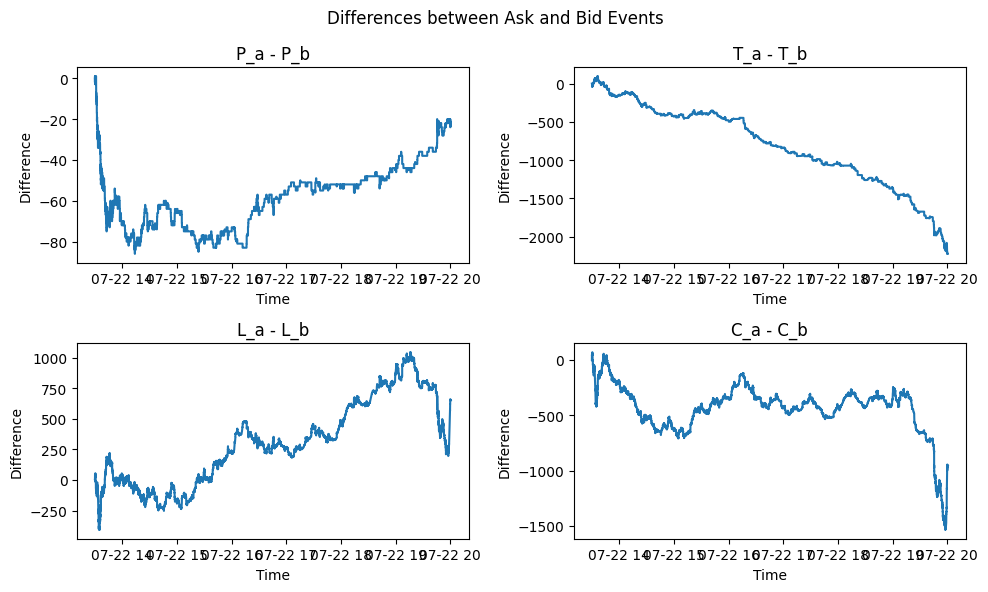

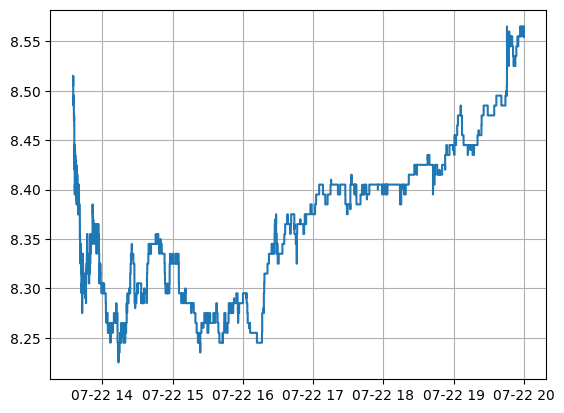

<Figure size 640x480 with 0 Axes>

In [6]:
# Plot differences between ask and bid events
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle('Differences between Ask and Bid Events')

# Plot P_a - P_b
ax1.plot(df['ts_event'], df['P_a'] - df['P_b'])
ax1.set_title('P_a - P_b')
ax1.set_xlabel('Time')
ax1.set_ylabel('Difference')

# Plot T_a - T_b  
ax2.plot(df['ts_event'], df['T_a'] - df['T_b'])
ax2.set_title('T_a - T_b')
ax2.set_xlabel('Time')
ax2.set_ylabel('Difference')

# Plot L_a - L_b
ax3.plot(df['ts_event'], df['L_a'] - df['L_b'])
ax3.set_title('L_a - L_b')
ax3.set_xlabel('Time')
ax3.set_ylabel('Difference')

# Plot C_a - C_b
ax4.plot(df['ts_event'], df['C_a'] - df['C_b'])
ax4.set_title('C_a - C_b')
ax4.set_xlabel('Time')
ax4.set_ylabel('Difference')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_diff_between_ask_and_bid_events.png")

plt.plot(df_price["ts_event"], df_price["mid_price"])
plt.grid()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_mid_price.png")





> Exp kernel on hawkes, after we will see others long term memory kernels

In [12]:
fraction = 0.05
# get the first 5% of the data
df = df.slice(0, int(len(df) * fraction))


In [13]:
# Fit multivariate Hawkes process to the data
import Hawkes as hk
import numpy as np
import matplotlib.pyplot as plt

# Convert timestamps to seconds since start
start_time = df["ts_event"].min()
times = (df["ts_event"] - start_time).cast(pl.Duration).dt.total_seconds().cast(pl.Float64).to_numpy()

# Get event times for each dimension
event_types = ['P_a', 'P_b', 'T_a', 'T_b', 'L_a', 'L_b', 'C_a', 'C_b']

# Create separate models for each event type
models = {}
for event_type in event_types:
    # Get event times for this type
    event_times = times[df[event_type].to_numpy() > 0]
    
    # Create and configure model
    model = hk.estimator()
    model.set_kernel('exp')  # Use exponential kernel
    model.set_baseline('const')  # Use constant baseline
    
    # Fit model
    itv = [float(times[0]), float(times[-1])]  # Observation interval
    try:
        model.fit(event_times, itv)
        models[event_type] = model
        print(f"\nResults for {event_type}:")
        print(model.get_params())
    except Exception as e:
        print(f"Error fitting model for {event_type}: {str(e)}")
        continue

# Plot intensities for successfully fitted models
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, event_type in enumerate(event_types):
    if event_type not in models:
        continue
        
    model = models[event_type]
    ax = axes[i]
    plt.sca(ax)  # Set current axis
    
    # Add event markers
    event_times = times[df[event_type].to_numpy() > 0]
    ymin, ymax = ax.get_ylim()
    ax.vlines(event_times, ymin=ymin, ymax=ymax, alpha=0.1, color='red')
    
    ax.set_title(f'Hawkes Process Intensity for {event_type}')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Intensity')
    ax.grid(True)

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_hawkes_intensity.png")

# Diagnostic plots for successfully fitted models
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, event_type in enumerate(event_types):
    if event_type not in models:
        continue
        
    model = models[event_type]
    ax = axes[i]
    plt.sca(ax)
    try:
        model.plot_KS()
        ax.set_title(f'KS Plot for {event_type}')
    except Exception as e:
        print(f"Error plotting KS plot for {event_type}: {str(e)}")
        continue

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_hawkes_diagnostics.png")


/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/Hawkes/model.py:643: RuntimeWarning: overflow encountered in multiply
  Int = Int + alpha[i] * ( np.exp( -beta[i] * x1 ) - np.exp( -beta[i] * x2 ) )
/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/Hawkes/model.py:655: RuntimeWarning: overflow encountered in multiply
  dInt[('alpha',i)] = np.exp( -beta[i] * x1 ) - np.exp( -beta[i] * x2 )
/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/Hawkes/model.py:656: RuntimeWarning: overflow encountered in multiply
  dInt[('beta',i) ] = alpha[i] * ( - x1 * np.exp( -beta[i] * x1 ) + x2 * np.exp( -beta[i] * x2 ) )
/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/Hawkes/model.py:180: RuntimeWarning: invalid value encountered in divide
  G = { key: (dl[key]/l).sum(axis=-1) - dInt[key] for key in dl }


KeyboardInterrupt: 

: 

Average arrival time

In [ ]:
# Compute average time between mid price changes
import numpy as np
import matplotlib.pyplot as plt

# Calculate time differences between mid price changes in nanoseconds and convert to milliseconds
time_diffs = df.with_columns(
    mid_price_change=pl.col("mid_price").diff()
).filter(
    pl.col("mid_price_change") != 0
).select(
    (pl.col("ts_event").diff().cast(pl.Int64) / 1_000_000).alias("time_diff_ms")  # Convert to milliseconds
).drop_nulls()

# Filter out times > 1 hour (3600000 milliseconds) 
time_diffs = time_diffs.filter(pl.col("time_diff_ms") <= 36000)

# Take first alpha fraction of data
alpha = 0.1  # Use first 10% of data
time_diffs_np = time_diffs.to_numpy().flatten()[:int(len(time_diffs) * alpha)]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(time_diffs_np, bins='auto', density=True, alpha=0.7)

plt.title(f'Distribution of Time Between Mid Price Changes (<1h) for {stock} (First {alpha*100}% of data)')
plt.xlabel('Time between mid price changes (milliseconds)')
plt.ylabel('Density')
plt.ylim(0,0.0002)
print('Average time between mid price changes:', time_diffs.mean())
avg_arrival_time = time_diffs.mean()["time_diff_ms"][0] 
plt.grid(True, alpha=0.3)

In [ ]:

# Save plot
os.makedirs(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/", exist_ok=True)
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_arrival_times.png")


In [ ]:
time_scales = [str(int(k*avg_arrival_time))+"us" for k in [1,5,10,30,100,1000,3000,10000,30000,100000,300000,1000000,3000000]]
print(time_scales)

In [ ]:
time_scales = time_scales

dfs = {}

for scale in time_scales:
    df_temp = df_cleaned.group_by(pl.col("ts_event").dt.truncate(scale)).agg([
        pl.col("mid_price").last().alias("mid_price")
    ])
    
    df_temp = df_temp.sort("ts_event")
    
    df_temp = df_temp.with_columns(
        tick_variation=pl.when(pl.col("ts_event").dt.date().diff() == 0)
        .then(pl.col("mid_price").diff()/avg_spread)
        .otherwise(None)
    )
    df_temp = df_temp.with_columns(
        log_variation=pl.when(pl.col("ts_event").dt.date().diff() == 0)
        .then(pl.col("mid_price").log().diff())
        .otherwise(None)
    )
    
    dfs[scale] = df_temp
    
    print(f"\n{scale} sampling:")
    print(df_temp.head())

In [ ]:
"""
import plotly.graph_objects as go

# Create plots for each time scale
for scale in time_scales:
    df_current = dfs[scale]
    
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=df_current["ts_event"], y=df_current["mid_price"], name="Mid Price")
    )
    fig.update_layout(
        title=f"{scale} Sampling",
        xaxis_title="Time", 
        yaxis_title="Mid Price"
    )
    fig.show()
"""

In [ ]:
# Calculate volatility under Bachelier model
# In Bachelier model, log returns are normally distributed with variance = sigma^2 * dt
# So sigma = sqrt(var(log returns) / dt)
for scale in time_scales:
    df_current = dfs[scale]
    
    # Add time difference column in seconds by converting nanoseconds to seconds
    df_current = df_current.with_columns(
        dt=pl.col("ts_event").diff().cast(pl.Int64) / 1e9  # Convert directly to seconds
    )
    
    # Calculate volatility using log variations and time differences, normalized by avg_spread
    df_current = df_current.with_columns(
        vol_bachelier=pl.when(pl.col("tick_variation").is_not_null())
        .then((pl.col("tick_variation").abs() / pl.col("dt").sqrt()) / avg_spread)
        .otherwise(None)
    )
    
    dfs[scale] = df_current
    
    # Print summary statistics
    print(f"\nBachelier volatility stats for {scale} sampling:")
    print(df_current.select("vol_bachelier").describe())


In [ ]:
# Plot histograms and time series of volatility for each sampling scale
import matplotlib.pyplot as plt

# Create subplots for histograms
fig_hist, axes_hist = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_hist.suptitle('Volatility Histograms by Sampling Scale')

# Create subplots for time series
fig_ts, axes_ts = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_ts.suptitle('Volatility Time Series by Sampling Scale')

for i, scale in enumerate(time_scales):
    df_current = dfs[scale]
    
    # Plot histogram
    vol_data = df_current.select('vol_bachelier').to_numpy().flatten()
    axes_hist[i].hist(vol_data[~np.isnan(vol_data)], bins=50, density=True)  # Remove NaN values
    axes_hist[i].set_title(f'{scale} Sampling')
    axes_hist[i].set_xlabel('Volatility')
    axes_hist[i].set_ylabel('Density')
    
    # Plot time series - first day only
    first_day = df_current.select('ts_event').to_numpy()[0].astype('datetime64[D]')
    mask = df_current.select('ts_event').to_numpy().astype('datetime64[D]') == first_day
    
    axes_ts[i].plot(df_current.select('ts_event').to_numpy()[mask], 
                    df_current.select('vol_bachelier').to_numpy()[mask])
    axes_ts[i].set_title(f'{scale} Sampling - First Day')
    axes_ts[i].set_xlabel('Time') 
    axes_ts[i].set_ylabel('Volatility')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_volatility_histograms_{threshold}.png")

In [ ]:
# Calculate volatility under Bachelier model
# In Bachelier model, log returns are normally distributed with variance = sigma^2 * dt
# So sigma = sqrt(var(log returns) / dt)
for scale in time_scales:
    df_current = dfs[scale]
    
    # Add time difference column in seconds by converting nanoseconds to seconds
    df_current = df_current.with_columns(
        dt=pl.col("ts_event").diff().cast(pl.Int64) / 1e9  # Convert directly to seconds
    )
    
    # Calculate volatility using log variations and time differences, normalized by avg_spread
    df_current = df_current.with_columns(
        vol_bachelier=pl.when(pl.col("log_variation").is_not_null())
        .then((pl.col("log_variation").abs() / pl.col("dt").sqrt()) / avg_spread)
        .otherwise(None)
    )
    
    dfs[scale] = df_current
    
    # Print summary statistics
    print(f"\nBachelier volatility stats for {scale} sampling:")
    print(df_current.select("log_variation").describe())


In [ ]:
# Plot histograms and time series of volatility for each sampling scale
import matplotlib.pyplot as plt

# Create subplots for histograms
fig_hist, axes_hist = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_hist.suptitle('Volatility Histograms by Sampling Scale')

# Create subplots for time series
fig_ts, axes_ts = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_ts.suptitle('Volatility Time Series by Sampling Scale')

for i, scale in enumerate(time_scales):
    df_current = dfs[scale]
    
    # Plot histogram
    vol_data = df_current.select('log_variation').to_numpy().flatten()
    axes_hist[i].hist(vol_data[~np.isnan(vol_data)], bins=50, density=True)  # Remove NaN values
    axes_hist[i].set_title(f'{scale} Sampling')
    axes_hist[i].set_xlabel('Volatility')
    axes_hist[i].set_ylabel('Density')
    
    # Plot time series - first day only
    first_day = df_current.select('ts_event').to_numpy()[0].astype('datetime64[D]')
    mask = df_current.select('ts_event').to_numpy().astype('datetime64[D]') == first_day
    
    axes_ts[i].plot(df_current.select('ts_event').to_numpy()[mask], 
                    df_current.select('log_variation').to_numpy()[mask])
    axes_ts[i].set_title(f'{scale} Sampling - First Day')
    axes_ts[i].set_xlabel('Time') 
    axes_ts[i].set_ylabel('Volatility')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_volatility_histograms_{threshold}.png")
plt.close("all")

In [ ]:
for scale in time_scales:
    # describe all columns
    print(dfs[scale].describe())

In [33]:
time_scales = time_scales[::-1]

In [ ]:
#plot autocorrelation of log variations

for scale in tqdm(time_scales[::-1], "Calculating autocorrelation for each scale"):
    # to npy and remove nans
    print(scale)
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    n = len(log_var)
    lags = np.arange(n)
    autocorr = np.array([np.corrcoef(log_var[:-lag], log_var[lag:])[0,1] if lag > 0 else 1 for lag in lags])

    plt.plot(lags, autocorr)
    plt.title(f"Autocorrelation of Log Variations - {scale} Sampling")
    plt.xlabel("Lag")
    plt.grid()
    plt.ylabel("Autocorrelation")
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_autocorrelation_{scale}log_var_vanilla.png")


In [ ]:
#plot autocorrelation of log variations

for scale in tqdm(time_scales[::-1], "Calculating autocorrelation for each scale"):
    # to npy and remove nans
    print(scale)
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    log_var = log_var * log_var
    n = len(log_var)
    lags = np.arange(n)
    autocorr = np.array([np.corrcoef(log_var[:-lag], log_var[lag:])[0,1] if lag > 0 else 1 for lag in lags])

    plt.plot(lags[:min(500,len(lags)//5)], autocorr[:min(500,len(lags)//5)])
    plt.title(f"Autocorrelation of Log Variations - {scale} Sampling")
    plt.xlabel("Lag")
    plt.grid()
    plt.yscale("log")
    plt.ylabel("Autocorrelation")
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_autocorrelation_{scale}_squared_logvar_betterviz_500_log.png")


In [ ]:
# Compute volatility as rolling mean of squared log variations
window_size = 20  # Number of periods to use for rolling window

for scale in time_scales:
    # Square the log variations 
    dfs[scale] = dfs[scale].with_columns(
        pl.col("log_variation").pow(2).alias("squared_log_var")
    )
    
    # Calculate rolling mean volatility
    dfs[scale] = dfs[scale].with_columns(
        pl.col("squared_log_var")
        .rolling_mean(window_size=window_size)
        .sqrt()  # Take sqrt to get volatility in original units
        .alias("rolling_volatility")
    )

    # Plot the rolling volatility
    plt.figure(figsize=(10,6))
    # Get first day by filtering ts_event to only include data from the first date
    first_day = dfs[scale]["ts_event"].dt.date()[0]
    mask = dfs[scale]["ts_event"].dt.date() == first_day
    plt.plot(dfs[scale].filter(mask)["ts_event"], dfs[scale].filter(mask)["rolling_volatility"])
    plt.title(f"Rolling Volatility ({window_size} period) - {scale} Sampling")
    plt.xlabel("Time")
    plt.ylabel("Volatility")
    plt.grid(True)
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_rolling_vol_{scale}.png")


In [ ]:
from hurst import compute_Hc

for scale in time_scales:
    # to npy and remove nans
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    H, c, data = compute_Hc(log_var)
    print(f"Hurst Exponent for {scale} Sampling: {H}")
    print(f"Hurst Exponent for {scale} Sampling: {H}")


In [ ]:
from hurst import compute_Hc

for scale in time_scales:
    # to npy and remove nans
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    log_var = log_var * log_var
    H, c, data = compute_Hc(log_var)
    print(f"Hurst Exponent for {scale} Sampling: {H}")
    print(f"Hurst Exponent for {scale} Sampling: {H}")


In [ ]:
import arch
import matplotlib.pyplot as plt
import numpy as np

for scale in time_scales:
    print(f"\nFitting GARCH model for {scale} sampling")
    
    # Get first day data only
    first_day = dfs[scale]["ts_event"].dt.date()[0]
    mask = dfs[scale]["ts_event"].dt.date() == first_day
    first_day_data = dfs[scale].filter(mask)
    
    # Get returns data for first day only
    returns = first_day_data.select("mid_price").to_numpy().flatten()
    
    # Create and fit GARCH(1,1) model with constant mean
    model = arch.arch_model(returns, mean='Constant', vol='GARCH', p=1, q=1)
    results = model.fit(disp='off')  # Suppress optimization output
    print(results.summary())

    # Get conditional volatility
    cvol = results.conditional_volatility
    
    # Get standardized residuals 
    stres = results.resid / cvol
    
    # Make predictions
    forecasts = results.forecast(horizon=3)
    
    # Plot conditional volatility
    plt.figure(figsize=(10,6))
    plt.plot(first_day_data["ts_event"], cvol)
    plt.title(f"GARCH Conditional Volatility - {scale} Sampling")
    plt.xlabel("Time") 
    plt.ylabel("Conditional Volatility")
    plt.grid(True)
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_garch_vol_{scale}.png")

    # Plot standardized residuals
    plt.figure(figsize=(10,6))
    plt.plot(first_day_data["ts_event"], stres)
    plt.title(f"GARCH Standardized Residuals - {scale} Sampling")
    plt.xlabel("Time")
    plt.ylabel("Standardized Residuals")
    plt.grid(True)
    plt.show()
    # vol extraction
    vol = cvol[~np.isnan(cvol)]
    vol1 = vol[len(vol)//2:]
    vol2 = vol[:len(vol)//2]
    H, c, data = compute_Hc(vol1)
    H2, c2, data2 = compute_Hc(vol2)
    print(f"Hurst Exponent for {scale} Sampling: {H}")
    print(f"Hurst Exponent for {scale} Sampling: {H2}")
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_garch_resid_{scale}.png")
